In [6]:
from SimPEG import *
from simpegEM1D import *
from scipy.constants import mu_0
import numpy as np

cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(15)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'ppm',
    src_type = 'VMD',
    offset = np.r_[8.],
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = np.r_[130100.]
)

sig_half = 1e-2
sig_blk = 1e-1
chi_half = 0.
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
sig[blk_ind] = sig_blk
prob = EM1D(
    mesh1D, sigma=sig,
    chi= np.zeros(FDsurvey.n_layer)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'hMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'inv', 'erf', 'floor', 'pi', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


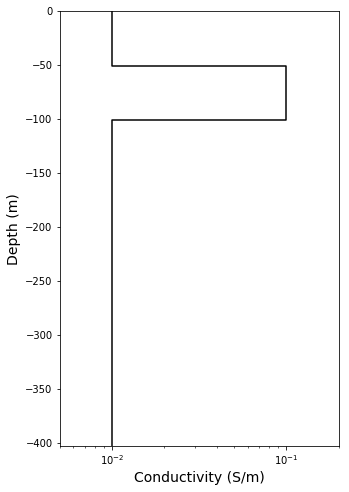

In [7]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)

In [8]:
mesh1D = Mesh.TensorMesh([1], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'ppm',
    src_type = 'VMD',
    offset = np.r_[8.],
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = np.r_[130100.],
    half_switch=True
)

sig_half = 1e-2
sig_blk = 1e0
chi_half = 0.
wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
# expmap_h = Maps.ExpMap(nP=1)
sigmaMap = expmap * wires.sigma
# hMap = expmap_h*wires.h
sig  = np.ones(1)*sig_half

prob = EM1D(
    mesh1D, sigmaMap=sigmaMap, hMap=wires.h,
    chi= np.zeros(FDsurvey.n_layer)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     

FDsurvey.dtrue = d_true
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)
m0 = np.r_[np.log(np.ones_like(sig)*sig_half*0.1), FDsurvey.h]
reg_sigma = Regularization.Sparse(
    mesh1D, mapping=wires.sigma,
    alpha_s = 0.01
)
p=0.
qx, qz = 2., 2.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    betaSearch=False,
    chifact_start = 1.
)
mesh_h = Mesh.TensorMesh([1])
reg_h = Regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1., alpha_x=0.
)
reg = reg_sigma + reg_h
opt = Optimization.ProjectedGNCG(maxIter = 20)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1.)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.04e+03  1.58e+02  0.00e+00  1.58e+02    1.05e+02      0              
   1  1.52e+03  3.59e+01  9.39e-03  5.02e+01    4.16e+01      0              
   2  7.60e+02  1.02e+01  1.82e-02  2.40e+01    1.92e+01      0   Skip BFGS  
   3  3.80e+02  2.98e+00  2.40e-02  1.21e+01    9.55e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1

In [9]:
print (wires.h*m0, wires.h*mopt, FDsurvey.h)
print (sigmaMap*m0, sig, sigmaMap*mopt)

[30.] [29.99967584] 30.0
[0.001] [0.01] [0.01041206]
